In [1]:
import open3d as o3d
import numpy as np
from open3d.examples import open3d_example as o3dtut
from stl import mesh
%matplotlib widget
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [16]:
data = torch.load("data_attacked/pgdl2/dgcnn/ATK_2023_09_25__16_33_08.pt")
#data = torch.load("data_dict.pt")

# data = np.load("all_data_5.npy", allow_pickle=True).item()

# data.keys()
# data["pc"] = data["pc"].squeeze()
# item = data


# data['pc'].shape

In [17]:
LABELS = ['bareteeth', 'cheeks_in', 'eyebrow', 'high_smile',
          'lips_back', 'lips_up', 'mouth_down', 'mouth_extreme',
          'mouth_middle', 'mouth_open', 'mouth_side', 'mouth_up']
LABEL_STR2INT = {label:i for i,label in enumerate(LABELS)}
LABEL_INT2STR = {i:label for i,label in enumerate(LABELS)}

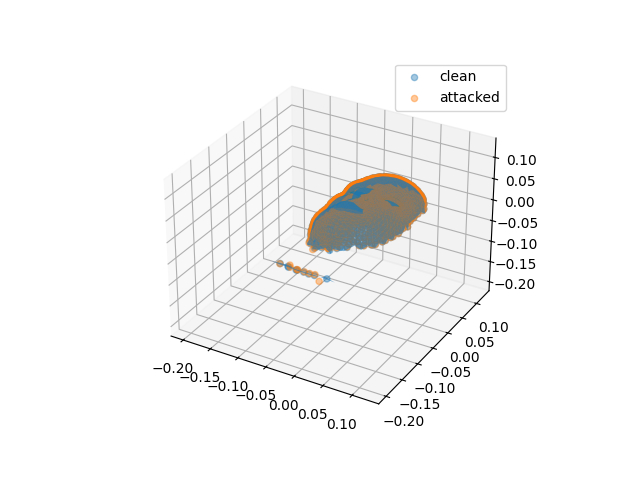

In [26]:
idx = 30

item = data[idx]

pc_clean = item["pc"]
pc_attacked = item["attacked"]
shift = item["shift"].squeeze()
scale = item["scale"].squeeze()

pc_clean = pc_clean*scale + shift 
pc_attacked = pc_attacked*scale + shift 

# pc_attacked = (pc_attacked - shift) / scale
#true_label = item["cate"].item()
#clean_pred = item["clean_pred"].item()
#attack_pred = item["attack_pred"].item()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.add_collection3d(mplot3d.art3d.Poly3DCollection(item["meshvectors"], alpha=0.6))
#Add the 3D faces to the created matplotlib axes
min_val = item["meshvectors"].reshape(-1).min()
max_val = item["meshvectors"].reshape(-1).max()
# Find min & max units to plate the 
ax.auto_scale_xyz([min_val, max_val],[min_val, max_val],[min_val, max_val])

#print("True label:", LABEL_INT2STR[true_label])
#print("Clean pred:", LABEL_INT2STR[clean_pred])
#print("Attack pred:", LABEL_INT2STR[attack_pred])
# print(LABEL_INT2STR[item["target"].item()])
ax.scatter3D(pc_clean[:,0], pc_clean[:,1], pc_clean[:,2], label="clean", alpha=0.4)
ax.scatter3D(pc_attacked[:,0], pc_attacked[:,1], pc_attacked[:,2], label="attacked", alpha=0.4)
plt.legend()
plt.show()